In [2]:
import numpy as np
import pandas as pd
import sklearn

import time
import os
import re
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

C:\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


# Summary:
* Load the csv's created by the harvester
* remove nans and duplicates
* extract the primary label
* select features (throw away *id*, *authors* and subcategories ans secondary categories)
* examine volumes of each label
* remove two categories altogether (*econ*, *eess*)
* save to file (*./data/bare_all.csv)

### Sidenote: if one ever wants know more about any of the articles, display its metadata with proper formatting or reach the actual pdf, it is enough to simply search the internet for the '*id*' (or 'arxiv *id*' in the worst case).

## Load the data

In [3]:
# dir_ = os.path.join("data", "arXivMeta_sample")
dir_ = os.path.join("data", "arXivMeta_all")

file_list = []
for file in os.listdir(dir_):
    file_path = os.path.join(dir_, file)
    file_list.append(file_path)
    print(f"using {file}")
    
all_data = pd.concat([pd.read_csv(file, delimiter='\t', na_values='nan') for file in file_list])

using arXivMeta_all_from_2010-01-01_to_2010-07-01.csv
using arXivMeta_all_from_2010-07-02_to_2010-12-31.csv
using arXivMeta_all_from_2011-01-01_to_2011-07-01.csv
using arXivMeta_all_from_2011-07-02_to_2011-12-31.csv
using arXivMeta_all_from_2012-01-01_to_2012-07-01.csv
using arXivMeta_all_from_2012-07-02_to_2012-12-31.csv
using arXivMeta_all_from_2013-01-01_to_2013-07-01.csv
using arXivMeta_all_from_2013-07-02_to_2013-12-31.csv
using arXivMeta_all_from_2014-01-01_to_2014-07-01.csv
using arXivMeta_all_from_2014-07-02_to_2014-12-31.csv
using arXivMeta_all_from_2015-01-01_to_2015-07-01.csv
using arXivMeta_all_from_2015-07-02_to_2015-12-31.csv
using arXivMeta_all_from_2016-01-01_to_2016-07-01.csv
using arXivMeta_all_from_2016-07-02_to_2016-12-31.csv
using arXivMeta_all_from_2017-01-01_to_2017-07-01.csv
using arXivMeta_all_from_2017-07-02_to_2017-12-31.csv


## Handle NaNs

In [4]:
# count the NaNs
all_data.isnull().sum()

id            10
authors        0
title         10
abstract      10
categories    10
dtype: int64

In [5]:
# show the NaNs
rows_with_nulls = all_data.isnull().any(axis=1)
print("No. of rows with NaNs: ", sum(rows_with_nulls))
all_data[rows_with_nulls][:3]

No. of rows with NaNs:  10


,id,authors,title,abstract,categories
22299,NaN,[],NaN,NaN,NaN
22300,NaN,[],NaN,NaN,NaN
23584,NaN,[],NaN,NaN,NaN


In [6]:
# All the NaNs are aligned in empty rows.
# We can just drop them.
all_data = all_data.dropna(axis=0, how='any', inplace=False)
all_data.isnull().sum().sum()

0

## Remove records that start with *This paper has been withdrawn* etc.

In [7]:
redflags = re.compile(r'^\s*(?:This paper has been withdrawn)|(?:arXiv admin note: This submission has been withdrawn)|(?:Withdrawn by arXiv)|(?:Admin note: withdrawn by arXiv)')

withdrawn = all_data.abstract.str.contains(redflags)

print(sum(withdrawn))
all_data = all_data[~withdrawn]

365


## Remove suspiciously short abstracts
There are articles where the abstract serves as a comment rather than a summary, e.g. "Discussion on SOME_REFERENCE."

In [8]:
example = all_data[all_data.id == '1001.2975'].abstract.values[0].strip()
print(example)
len(example)

Comment on "Harold Jeffreys's Theory of Probability Revisited"
[arXiv:0804.3173]


80

Let's just decide that abstracts shorter than 100 characters are noise rather than information and remove them.

In [9]:
tresh = 100
print("Removing", sum(all_data.abstract.str.len() < tresh), f"records with abstracts shorter than {tresh}")
all_data = all_data.loc[all_data.abstract.str.len() > tresh]

Removing 1903 records with abstracts shorter than 100


## Check for repeated entries

In [10]:
# Count remaining duplicates in each column separately

print("No. repeated entries in column:")
for column in all_data:
    print( f"{column:<11}", len(all_data) - len(all_data[column].unique()) )

No. repeated entries in column:
id          0
authors     214077
title       1051
abstract    404
categories  801558


In [11]:
# As a sidenote, recall how does the *duplicated* function in pandas actually work.
# It flags the duplicates starting from the second repeated entry.

df = pd.DataFrame({'a': [1,1,1], 'b': [2,2,3], 'c': [4,5,6]})
print(df.duplicated(subset=['a','b']))

# To get all repeats use the *keep=False* argument
print(df.duplicated(subset=['a','b'], keep=False))

0    False
1     True
2    False
dtype: bool
0     True
1     True
2    False
dtype: bool


In [12]:
# Back to our data.
# There are entries with duplicated abstracts and matching categories.
# The fact that they may have differing titles and authors is fishy but
# it's probably due to typo in the title or added authors

subset=['abstract', 'categories']
duplicates_1 = all_data[all_data.duplicated(subset=subset, keep=False)]
display(pd.concat(g for _, g in duplicates_1.groupby(subset) ))

# This data represents unambiguous mapping from abstracts to categories
# so we want to retain one entry from each bunch of duplicates

print(f"Something wrong with ids, authors or titles above. Keep one of each unique abstract.")
all_data = all_data.drop_duplicates(subset=subset)

,id,authors,title,abstract,categories
10250,1108.4675,"['David Eppstein', 'Michael T. Goodrich', 'Maa...",Category-Based Routing in Social Networks: Mem...,A classic experiment by Milgram shows that i...,cs.SI cs.DS physics.soc-ph
24917,1110.4499,"['David Eppstein', 'Michael T. Goodrich', 'Maa...",Category-Based Routing in Social Networks: Mem...,A classic experiment by Milgram shows that i...,cs.SI cs.DS physics.soc-ph
21171,1602.00361,['Hyun Kyu Kim'],Phase constants in the Fock-Goncharov quantiza...,A cluster variety of Fock and Goncharov is a...,math.QA math.GT math.RT
21369,1602.00797,['Hyun Kyu Kim'],Phase constants in the Fock-Goncharov quantiza...,A cluster variety of Fock and Goncharov is a...,math.QA math.GT math.RT
22632,1306.0621,"['S. Wimmer', 'D. Ködderitzsch', 'K. Chadova',...",A first-principles linear response description...,A first-principles description of the spin N...,cond-mat.mtrl-sci cond-mat.mes-hall
30836,1311.5047,"['S. Wimmer', 'D. Ködderitzsch', 'K. Chadova',...","Supplemental Material to ""A first-principles l...",A first-principles description of the spin N...,cond-mat.mtrl-sci cond-mat.mes-hall
161858,cond-mat/9912300,['A. M. Shvaika'],Dynamical susceptibilities in strong coupling ...,A general scheme to calculate dynamical susc...,cond-mat.str-el
79829,cond-mat/0203492,['A. M. Shvaika'],Dynamical susceptibilities in strong coupling ...,A general scheme to calculate dynamical susc...,cond-mat.str-el
36280,nucl-ex/0009013,['T. Peitzmann'],Direct Photon Production in 158 AGeV Pb+Pb Col...,A measurement of direct photon production in...,nucl-ex
36281,nucl-ex/0009014,['T. Peitzmann'],Direct Photon Production in 158 AGeV Pb+Pb Col...,A measurement of direct photon production in...,nucl-ex


Something wrong with ids, authors or titles above. Keep one of each unique abstract.


In [13]:
# Now, remaining duplicated abstracts must have differing categories at this point.
# Thus, those records are ambigous for our purposes, and we may want to drop them all.
# Alas, the differing categories are probably 'close'. So, to not throw away reasonably informative data
# but to still keep unambiguous abstract->categories map, we'll again keep one of the duplicates
# One may add *keep=False* to *drop_duplicates* below, in order to remove them all.

subset=['abstract']
duplicates_2 = all_data[all_data.duplicated(subset=subset, keep=False)]
display(pd.concat(g for _, g in duplicates_2.groupby(subset) ))

print(f"Ambiguous categories. Keep one of each unique abstract.")
all_data = all_data.drop_duplicates(subset=subset)
# all_data = all_data.drop_duplicates(subset=subset, keep=False)

,id,authors,title,abstract,categories
10540,1407.2169,"['Cyril Voyant', 'Wani W. Tamas', 'Marie Laure...",Meteorological time series forecasting with pr...,A Multi-Layer Perceptron (MLP) defines a fam...,cs.NE cs.SY
110188,1308.1940,"['Cyril Voyant', 'Wani W. Tamas', 'Christophe ...",Time series modeling with pruned multi-layer p...,A Multi-Layer Perceptron (MLP) defines a fam...,cs.NE
3884,1206.1846,"['Tomoharu Iwata', 'David Duvenaud', 'Zoubin G...",Warped Mixtures for Nonparametric Cluster Shapes,A mixture of Gaussians fit to a single curve...,stat.ML
13955,1408.2061,"['Tomoharu Iwata', 'David Duvenaud', 'Zoubin G...",Warped Mixtures for Nonparametric Cluster Shapes,A mixture of Gaussians fit to a single curve...,cs.LG stat.ML
5202,1008.1530,"['Hugo Reinhardt', 'Markus Leder', 'Jan M. Paw...",Hamiltonian Flow of Yang-Mills Theory in Coulo...,A new functional renormalization group equat...,hep-lat hep-th
20642,1011.3462,"['Hugo Reinhardt', 'Markus Leder', 'Jan M. Paw...",Hamiltonian Dyson-Schwinger and FRG Flow Equat...,A new functional renormalization group equat...,hep-th
12083,1309.7546,['Liaofu Luo'],A Quantum Model on Chemically-Physically Induc...,A quantum model on the chemically and physic...,q-bio.OT
152650,1506.02053,['Liaofu Luo'],From Chemically to Physically Induced Pluripot...,A quantum model on the chemically and physic...,q-bio.BM
3060,1209.6561,"['Giorgos Borboudakis', 'Ioannis Tsamardinos']",Scoring and Searching over Bayesian Networks w...,A significant theoretical advantage of searc...,cs.AI cs.LG stat.ML
13951,1408.2057,"['Giorgos Borboudakis', 'Ioannis Tsamardinos']",Scoring and Searching over Bayesian Networks w...,A significant theoretical advantage of searc...,cs.AI


Ambiguous categories. Keep one of each unique abstract.


In [14]:
# At this point there are no duplicated abstracts.
# The duplicated titles could be examined and perhaps removed as well
# but we will not bother to do that

print("No. all records:", len(all_data))
print("No. repeated entries in column:")
for column in all_data:
    print( f"{column:<11}", len(all_data) - len(all_data[column].unique()) )

No. all records: 837973
No. repeated entries in column:
id          0
authors     213817
title       913
abstract    0
categories  801163


---

## Extract the first category as the primary category of each article

In [15]:
# Although it is not visibly indicated in the dataset,
# the first categories in a list are the primary_categories of each article.
# We make a new column for them.

primary_categories = all_data.categories.str.split().str[0]
all_data['primary_cat'] = primary_categories
all_data[9:12]

,id,authors,title,abstract,categories,primary_cat
9,0704.0842,['Chengguang Bao'],Oscillation bands of condensates on a ring: Be...,The Hamiltonian of a N-boson system confined...,cond-mat.other,cond-mat.other
10,0704.1074,"['Satoshi Aoki', 'Takayuki Hibi', 'Hidefumi Oh...",Markov basis and Groebner basis of Segre-Veron...,We consider testing independence in group-wi...,math.ST math.AC stat.AP stat.TH,math.ST
11,0704.1083,['Laurent Berger'],"B-pairs and (phi,Gamma)-modules",Main change from v1 : theorem C has been mod...,math.NT math.AG,math.NT


---

## Map all the categories into top-level topics (*physics*, *mathematics*, etc.)

### Start with creating a mapping

In [16]:
# Read in categories described in the *arXiv_metadata_harvester.ipynb*

from my_utilities import read_dict

physics_genres = read_dict("physics_genres.txt")
print(physics_genres) # That's just what arXiv's API told us

top_cats = read_dict("top_cats.txt")
top_cats # We want those as labels for our categories

{'astro-ph': 'Astrophysics', 'cond-mat': 'Condensed Matter', 'gr-qc': 'General Relativity and Quantum Cosmology', 'hep-ex': 'High Energy Physics - Experiment', 'hep-lat': 'High Energy Physics - Lattice', 'hep-ph': 'High Energy Physics - Phenomenology', 'hep-th': 'High Energy Physics - Theory', 'math-ph': 'Mathematical Physics', 'nlin': 'Nonlinear Sciences', 'nucl-ex': 'Nuclear Experiment', 'nucl-th': 'Nuclear Theory', 'physics': 'Physics (Other)', 'quant-ph': 'Quantum Physics'}


{'cs': 'Computer Science',
 'econ': 'Economics',
 'eess': 'Electrical Engineering and Systems Science',
 'math': 'Mathematics',
 'physics': 'Physics',
 'q-bio': 'Quantitative Biology',
 'q-fin': 'Quantitative Finance',
 'stat': 'Statistics'}

In [17]:
# Let's have a look at all possible categories

categories_set = set()
for cats in all_data.categories.str.split():
    categories_set.update(set(cats))

categories = pd.Series(list(categories_set))

print(f"We have {len(categories)} unique category labels so far:")
categories_set

We have 173 unique category labels so far:


{'acc-phys',
 'adap-org',
 'alg-geom',
 'ao-sci',
 'astro-ph',
 'astro-ph.CO',
 'astro-ph.EP',
 'astro-ph.GA',
 'astro-ph.HE',
 'astro-ph.IM',
 'astro-ph.SR',
 'atom-ph',
 'bayes-an',
 'chao-dyn',
 'chem-ph',
 'cmp-lg',
 'comp-gas',
 'cond-mat',
 'cond-mat.dis-nn',
 'cond-mat.mes-hall',
 'cond-mat.mtrl-sci',
 'cond-mat.other',
 'cond-mat.quant-gas',
 'cond-mat.soft',
 'cond-mat.stat-mech',
 'cond-mat.str-el',
 'cond-mat.supr-con',
 'cs.AI',
 'cs.AR',
 'cs.CC',
 'cs.CE',
 'cs.CG',
 'cs.CL',
 'cs.CR',
 'cs.CV',
 'cs.CY',
 'cs.DB',
 'cs.DC',
 'cs.DL',
 'cs.DM',
 'cs.DS',
 'cs.ET',
 'cs.FL',
 'cs.GL',
 'cs.GR',
 'cs.GT',
 'cs.HC',
 'cs.IR',
 'cs.IT',
 'cs.LG',
 'cs.LO',
 'cs.MA',
 'cs.MM',
 'cs.MS',
 'cs.NA',
 'cs.NE',
 'cs.NI',
 'cs.OH',
 'cs.OS',
 'cs.PF',
 'cs.PL',
 'cs.RO',
 'cs.SC',
 'cs.SD',
 'cs.SE',
 'cs.SI',
 'cs.SY',
 'dg-ga',
 'econ.EM',
 'eess.AS',
 'eess.IV',
 'eess.SP',
 'funct-an',
 'gr-qc',
 'hep-ex',
 'hep-lat',
 'hep-ph',
 'hep-th',
 'math-ph',
 'math.AC',
 'math.AG',
 'm

In [18]:
# Extract the first level categorization, i.e. up to a dot or end of string,
# e.g. cond-mat.quant-gas -> cond-mat, cs.AI -> cs

strip_pattern = re.compile(r'([\w\-]+)')

def strip_to_semitop(cat, pattern=strip_pattern):
    return strip_pattern.match(cat).group(1)

semitop_categories = categories.map(strip_to_semitop)
semitop_categories_set = set(semitop_categories)    

semitop_categories_set

{'acc-phys',
 'adap-org',
 'alg-geom',
 'ao-sci',
 'astro-ph',
 'atom-ph',
 'bayes-an',
 'chao-dyn',
 'chem-ph',
 'cmp-lg',
 'comp-gas',
 'cond-mat',
 'cs',
 'dg-ga',
 'econ',
 'eess',
 'funct-an',
 'gr-qc',
 'hep-ex',
 'hep-lat',
 'hep-ph',
 'hep-th',
 'math',
 'math-ph',
 'mtrl-th',
 'nlin',
 'nucl-ex',
 'nucl-th',
 'patt-sol',
 'physics',
 'plasm-ph',
 'q-alg',
 'q-bio',
 'q-fin',
 'quant-ph',
 'solv-int',
 'stat',
 'supr-con'}

In [19]:
# Try to create map from semitop_categories to top_cats using physic_genres

to_top = {}

for top_cat in top_cats:
    to_top[top_cat] = top_cat
    
for genre in physics_genres:
    # writes over to_top[physics]=physics
    to_top[genre] = "phys"
    
to_top

{'cs': 'cs',
 'econ': 'econ',
 'eess': 'eess',
 'math': 'math',
 'physics': 'phys',
 'q-bio': 'q-bio',
 'q-fin': 'q-fin',
 'stat': 'stat',
 'astro-ph': 'phys',
 'cond-mat': 'phys',
 'gr-qc': 'phys',
 'hep-ex': 'phys',
 'hep-lat': 'phys',
 'hep-ph': 'phys',
 'hep-th': 'phys',
 'math-ph': 'phys',
 'nlin': 'phys',
 'nucl-ex': 'phys',
 'nucl-th': 'phys',
 'quant-ph': 'phys'}

In [20]:
# let's see which semitop_categories will not be mapped by the 'to_top' dict

semitop_categories[pd.isnull(semitop_categories.map(to_top))]

9      solv-int
23      atom-ph
29     supr-con
35     comp-gas
37        q-alg
39        dg-ga
48     bayes-an
53       ao-sci
57     alg-geom
70       cmp-lg
75     chao-dyn
84      mtrl-th
109    patt-sol
110    adap-org
114    plasm-ph
115     chem-ph
149    funct-an
159    acc-phys
dtype: object

In [21]:
# We just google those, see how arXiv displays them on its frontend, and assign them by hand below

clean_up_mask = {}
clean_up_mask['acc-phys'] = 'physics'
clean_up_mask['adap-org'] = 'nlin'
clean_up_mask['alg-geom'] = 'math'
clean_up_mask['atom-ph'] = 'physics'
clean_up_mask['chao-dyn'] = 'nlin'
clean_up_mask['comp-gas'] = 'nlin'
clean_up_mask['dg-ga'] = 'math'
clean_up_mask['funct-an'] = 'math'
clean_up_mask['q-alg'] = 'math'
clean_up_mask['solv-int'] = 'nlin'
clean_up_mask['patt-sol'] = 'nlin'
clean_up_mask['bayes-an'] = 'physics'
clean_up_mask['supr-con'] = 'cond-mat'
clean_up_mask['chem-ph'] = 'physics'
clean_up_mask['mtrl-th'] = 'cond-mat'
clean_up_mask['cmp-lg'] = 'cs'
clean_up_mask['comp-gas'] = 'nlin'
clean_up_mask['ao-sci'] = 'physics'
clean_up_mask['plasm-ph'] = 'physics'


def clean_up(cat):
    if cat in clean_up_mask:
        return clean_up_mask[cat]
    else:
        return cat


print("Uknown categories:\n", semitop_categories[pd.isnull( semitop_categories.map(clean_up).map(to_top) )] )
print("No. unknown categories:", sum( pd.isnull( semitop_categories.map(clean_up).map(to_top) ) ) )

Uknown categories:
 Series([], dtype: object)
No. unknown categories: 0


### Apply the map

In [22]:
# Ok, assuming there are no uknown categories above,
# we can apply the *strip_to_semitop*, *clean_up* and *to_top* maps to our original categories in the data-frame.
# Pack those three into a vectorized function

def lift_category(cat):
    return to_top[clean_up(strip_to_semitop(cat))]

lift_category = np.vectorize(lift_category)

In [23]:
# # For example

# nico = pd.DataFrame({'a':['cs.AI chao-dyn hep-th']})
# display(nico)

# nico.a = nico.a.str.split().map(lift_category).map(np.unique)
# nico

In [24]:
all_data['top_level_cats'] = all_data.categories.str.split().map(lift_category).map(np.unique)
all_data['primary_top_level_cat'] = all_data.primary_cat.map(lift_category)

In [25]:
all_data[9:12]

,id,authors,title,abstract,categories,primary_cat,top_level_cats,primary_top_level_cat
9,0704.0842,['Chengguang Bao'],Oscillation bands of condensates on a ring: Be...,The Hamiltonian of a N-boson system confined...,cond-mat.other,cond-mat.other,[phys],phys
10,0704.1074,"['Satoshi Aoki', 'Takayuki Hibi', 'Hidefumi Oh...",Markov basis and Groebner basis of Segre-Veron...,We consider testing independence in group-wi...,math.ST math.AC stat.AP stat.TH,math.ST,"[math, stat]",math
11,0704.1083,['Laurent Berger'],"B-pairs and (phi,Gamma)-modules",Main change from v1 : theorem C has been mod...,math.NT math.AG,math.NT,[math],math


---

## Examine the multi-labeldness of data
Our main goal is to predict the *primary_top_level_cat*, but some articles have more than one category in *top_level_cats*. 
Perhaps one could predict the whole list (i.e. several yes/no checks) as well.
For starters let's examine how big a franction of the data has more than one top-level categories

In [26]:
inter6 = sum(all_data.top_level_cats.map(len)>=6)
inter5 = sum(all_data.top_level_cats.map(len)==5)
inter4  = sum(all_data.top_level_cats.map(len)==4)
inter3  = sum(all_data.top_level_cats.map(len)==3)
inter2  = sum(all_data.top_level_cats.map(len)==2)
inter1  = sum(all_data.top_level_cats.map(len)==1)
# inter0  = sum(all_data.top_level_cats.map(len)==0)  # sanity check
inter = inter6 + inter5 + inter4 + inter3 + inter2

print(f"{inter6:>7}/{len(all_data)}={inter6/len(all_data):.3f} with 6 or more categories")
print(f"{inter5:>7}/{len(all_data)}={inter5/len(all_data):.3f} with 5 categories")
print(f"{inter4:>7}/{len(all_data)}={inter4/len(all_data):.3f} with 4 categories")
print(f"{inter3:>7}/{len(all_data)}={inter3/len(all_data):.3f} with 3 categories")
print(f"{inter2:>7}/{len(all_data)}={inter2/len(all_data):.3f} with 2 categories")
print(f"{inter1:>7}/{len(all_data)}={inter1/len(all_data):.3f} with 1 category")
# print(f"{inter0:>7}/{len(all_data)} articles with no category")
print(f"{inter:>7}/{len(all_data)}={inter/len(all_data):.3f} with 2 or more categories")

      0/837973=0.000 with 6 or more categories
     22/837973=0.000 with 5 categories
    450/837973=0.001 with 4 categories
   7760/837973=0.009 with 3 categories
 101192/837973=0.121 with 2 categories
 728549/837973=0.869 with 1 category
 109424/837973=0.131 with 2 or more categories


### 87% percept of records have single top-level category, 1% have three or more. So, we'll focus on single-label classification using the *primary top-level category* (simply referred to as *category* from now on) .

In [27]:
# Have a look at the most interdisciplinary articles :)
all_data[all_data.top_level_cats.map(len)>=5]

,id,authors,title,abstract,categories,primary_cat,top_level_cats,primary_top_level_cat
19119,1001.0036,"['Robert Haslinger', 'Kristina Lisa Klinkner',...",The Computational Structure of Spike Trains,"Neurons perform computations, and convey the...",q-bio.NC cs.IT math.IT nlin.AO physics.data-an...,q-bio.NC,"[cs, math, phys, q-bio, stat]",q-bio
18529,0911.4207,"['Rafael S. Calsaverini', 'Renato Vicente']",An information theoretic approach to statistic...,We discuss the connection between informatio...,q-fin.ST cs.IT math.IT physics.data-an stat.AP,q-fin.ST,"[cs, math, phys, q-fin, stat]",q-fin
28407,1112.0210,"['Karol Wawrzyniak', 'Wojciech Wislicki']",Mesoscopic approach to minority games in herd ...,We study minority games in efficient regime....,nlin.AO cs.MA math.DS q-fin.TR stat.AP,nlin.AO,"[cs, math, phys, q-fin, stat]",phys
30710,cs/0111054,"['Ming Li', 'Xin Chen', 'Xin Li', 'Bin Ma', 'P...",The similarity metric,A new class of distances appropriate for mea...,cs.CC cond-mat.stat-mech cs.CE cs.CV math.CO m...,cs.CC,"[cs, math, phys, q-bio, stat]",cs
30769,cs/0606048,"['Rudi Cilibrasi', 'Paul M. B. Vitanyi']",A New Quartet Tree Heuristic for Hierarchical ...,We consider the problem of constructing an a...,cs.DS cs.CV cs.DM math.ST physics.data-an q-bi...,cs.DS,"[cs, math, phys, q-bio, stat]",cs
13531,0803.2443,['Jens Christian Claussen'],"Discrete stochastic processes, replicator and ...",Finite-size fluctuations in coevolutionary d...,q-bio.PE cond-mat.stat-mech cs.SI math.PR math...,q-bio.PE,"[cs, math, phys, q-bio, stat]",q-bio
19235,1206.3543,"['V. J. Vieland', 'J. Das', 'S. E. Hodge', 'S....",Measurement of statistical evidence on an abso...,Statistical analysis is used throughout biom...,math.ST cs.IT math.IT physics.data-an q-bio.QM...,math.ST,"[cs, math, phys, q-bio, stat]",math
21791,1208.4384,"['Joshua C. Chang', 'Tom Chou']",Iterative graph cuts for image segmentation wi...,Shape-based regularization has proven to be ...,cs.CV math.OC physics.data-an q-bio.QM stat.AP,cs.CV,"[cs, math, phys, q-bio, stat]",cs
5158,1312.6661,['Justin B. Kinney'],Rapid and deterministic estimation of probabil...,The question of how best to estimate a conti...,physics.data-an cs.LG math.ST q-bio.QM stat.ML...,physics.data-an,"[cs, math, phys, q-bio, stat]",phys
7368,1106.3703,"['Artemy Kolchinsky', 'Luis M. Rocha']",Prediction and Modularity in Dynamical Systems,Identifying and understanding modular organi...,nlin.AO cs.AI cs.IT cs.LG cs.SY math.IT q-bio....,nlin.AO,"[cs, math, phys, q-bio, stat]",phys


---

## Plot the volume of data in each category

In [28]:
def show_cats(df, column = 'primary_top_level_cat'):
    
    cats = df[column].unique()
    record_counts = []
    
    for cat in cats:
        count = sum(df[column] == cat)
        record_counts.append( [cat, count/1000] )
    
    record_counts = sorted(record_counts, key = lambda x: x[1], reverse=True)
    
    record_counts = np.array(record_counts)
    record_counts_df = pd.DataFrame({'categories': record_counts[:,0], '1000 papers': record_counts[:,1]}).set_index('categories')
    display(record_counts_df)
    record_counts_df.astype('float').plot.bar()
    plt.show()

,1000 papers
categories,
phys,506.621
math,190.765
cs,110.462
stat,14.591
q-bio,10.592
q-fin,4.627
eess,0.28
econ,0.035


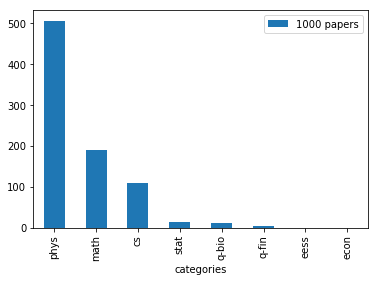

In [29]:
show_cats(all_data)

## Drop the least frequent categories: *Economics* and *Electrical Engineering and Systems Science*
The *eess* and *econ* categories had started only in year 2017. We are not ambitious enough at this point to include them in the classification. We will exculde them completely from our data, as if those categories did not exist in the world.

,1000 papers
categories,
phys,505.925
math,190.564
cs,110.296
stat,14.565
q-bio,10.578
q-fin,4.623


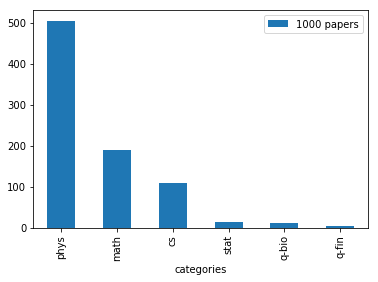

In [30]:
filter_ = np.vectorize(lambda cat: cat in ['econ', 'eess'])
drop_mask = filter_(all_data.primary_top_level_cat)

all_data = all_data.drop(all_data[drop_mask].index)
show_cats(all_data)

---

## Strip the data down to *text* + *label*

In [31]:
bare_data = pd.DataFrame()

In [32]:
bare_data['text'] = all_data.title + " " + all_data.abstract
bare_data['label'] = all_data.primary_top_level_cat

In [33]:
with pd.option_context('display.max_colwidth', 120):
    display(bare_data[:3])

,text,label
0,"The Spitzer c2d Survey of Large, Nearby, Insterstellar Clouds. IX. The\n Serpens YSO Population As Observed With IR...",phys
1,"On-line Viterbi Algorithm and Its Relationship to Random Walks In this paper, we introduce the on-line Viterbi alg...",cs
2,Dynamical Objects for Cohomologically Expanding Maps The goal of this paper is to construct invariant dynamical ob...,math


---

## Write to file

In [35]:
# sanity check
bare_data.isnull().sum().sum()

0

In [36]:
file = os.path.join("data", "bare_all.csv")
bare_data.to_csv(file, sep = '\t', index = False)

---

### End

### old

In [7]:
# load the csv's obtained with 'arXiv_metadata_harvester.ipynb'

#dir_ = os.path.join("data", "arXivMeta_completed")
#dir_ = os.path.join("data", "arXivMeta_example_bak")

dfs = {}

# create dict of file-lists dfs = {'cs': [file1, ...], 'math': ..., etc.}
for file in os.listdir(dir_):
    info = re.search(r'arXivMeta_(.+?)_(.+?)\.(\w+?)', file)
    cat = info.group(1)
    date = info.group(2)
    print(f'{cat:>9}: {date}')
    
    file_path = os.path.join(dir_, file)
    
    if cat not in dfs:
        dfs[cat] = [file_path]
    else:
        dfs[cat].append(file_path)

# create dict of data_frames dfs = {'cs': pd.DataFrame(), 'math': ..., etc.}       
def getdf(file_list):
    cat_dfs = [pd.read_csv(file, delimiter='\t') for file in file_list]
    return pd.concat(cat_dfs)

dfs = {cat: getdf(cat_files) for (cat, cat_files) in dfs.items()}

       cs: from_2016-01-01_to_2016-12-31
     math: from_2016-01-01_to_2016-07-01
     math: from_2016-07-02_to_2016-12-31
  physics: from_2016-01-01_to_2016-05-01
  physics: from_2016-05-02_to_2016-09-01
  physics: from_2016-09-02_to_2016-12-31
    q-bio: from_2016-01-01_to_2016-12-31
    q-fin: from_2016-01-01_to_2016-12-31
     stat: from_2016-01-01_to_2016-12-31


---

# Explore and select the data

In [8]:
# now we have for example

dfs['math'][:3]

,id,prim_cat,sec_cats,title,abstract
0,0704.0189,math,math.GR,Monoid generalizations of the Richard Thompson...,"The groups G_{k,1} of Richard Thompson and G..."
1,0704.1313,math,math.GT math.CO,Mutant knots and intersection graphs,We prove that if a finite order knot invaria...
2,0704.2146,math,math.CO,Connected Edge-Disjoint Unions of Tur\'an Graphs,A finite connected graph $G_r^\sigma$ is con...


In [9]:
# check if there are no duplicates (at least by 'id')

[(cat, 0 == len(df.id) - len(df.id.unique())) for (cat,df) in dfs.items()]

[('cs', True),
 ('math', True),
 ('physics', True),
 ('q-bio', True),
 ('q-fin', True),
 ('stat', True)]

In [10]:
# concat all data_frames into one

full_df = pd.concat(dfs.values())

# get a 10% sample to play with

sample_df = full_df.sample(frac=0.1, random_state=123)
sample_df.reset_index(inplace=True)
len(sample_df)

16128

In [11]:
def show_cats(df):
    
    cats = df.prim_cat.unique()
    record_counts = []
    
    for cat in cats:
        count = sum(df.prim_cat == cat)
        record_counts.append( [cat, count/1000] )
    
    record_counts = sorted(record_counts, key = lambda x: x[1], reverse=True)
    
    record_counts = np.array(record_counts)
    record_counts_df = pd.DataFrame({'categories': record_counts[:,0], '1000 papers': record_counts[:,1]}).set_index('categories')
    display(record_counts_df)
    record_counts_df.astype('float').plot.bar()
    plt.show()

,1000 papers
categories,
physics,8.003
math,4.546
cs,2.62
stat,0.565
q-bio,0.295
q-fin,0.099


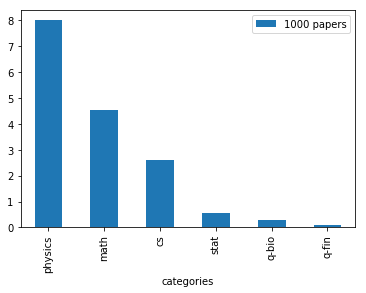

In [12]:
# plot the number of papers in each class
# the dataset is highly unbalanced, there's orders of magnitude between the most and the least frequent class

show_cats(sample_df)

# the world of quantative finance seems to be less keen on spending time writing papers than physicists

In [13]:
# get primary_categories (prim_cat) and text (title+abstract) only
# and safe those in 'bare data_frames'

def strip(df):
    df_2 = pd.concat([(df.title + " " + df.abstract).astype('str'),
                      df.prim_cat.astype('category')], axis=1)
    df_2.columns = ['text', 'label']
    return df_2

bare_dfs = {cat: strip(df) for (cat, df) in dfs.items()}

bare_sample_df = strip(sample_df)

In [14]:
# now we have for example

with pd.option_context('display.max_colwidth', 110):
    display(bare_sample_df[:3])

,text,label
0,The IBM 2016 Speaker Recognition System In this paper we describe the recent advancements made in the IB...,cs
1,The 2(2S+1)- Formalism and Its Connection with Other Descriptions In the framework of the Joos-Weinberg ...,math
2,Regression-based Intra-prediction for Image and Video Coding By utilizing previously known areas in an i...,cs


---

### One could also have a look at the papers' secondary categories of which there are almost 200 and there can be many such categories per paper. Maybe later...

In [15]:
# TODO side-project:
# classify by subcategories (first entries in the list in 'sec_cats' of each paper)

In [16]:
# one-hot-encode the 
ids_with_cats_ugly = full_df[['id', 'sec_cats']].set_index('id').sec_cats.str.split(expand=True).stack()
print(ids_with_cats_ugly[:10])

id_with_cats_df = pd.get_dummies(ids_with_cats_ugly).groupby(level=0).sum()
id_with_cats_df[:3]

id          
0704.0361  0      cs.IT
           1    math.IT
0704.0590  0      cs.IT
           1    math.IT
0704.0671  0      cs.IT
           1      cs.LG
           2    math.IT
0704.0805  0      cs.IT
           1    math.IT
0704.0858  0      cs.CR
dtype: object


,acc-phys,adap-org,alg-geom,ao-sci,astro-ph,astro-ph.CO,astro-ph.EP,astro-ph.GA,astro-ph.HE,astro-ph.IM,...,q-fin.TR,quant-ph,solv-int,stat.AP,stat.CO,stat.ME,stat.ML,stat.OT,stat.TH,supr-con
id,,,,,,,,,,,,,,,,,,,,,
0704.0189,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0704.0334,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0704.0345,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
len(id_with_cats_df.columns)

168

In [18]:
# TODO take care of adap-org (nlin.AO), chao-dyn(nlin.CD), patt-sol (nlin.PS) etc.:

# Each category should be in the format 'general.specic' (e.g. 'astr-ph.CO') or just 'general' (e.g. 'astro-ph')
# but some of our columns are assigned to 'specific' in the spelled-out format (eg. chao-dyn instead of nlin.CD)
# See https://arxiv.org/ and http://arxitics.com/help/categories

# for column in id_with_cats_df:
#     print(column)

---

### Abstracts of scientific papers tend to be written in a formal style, not contain typos, no direct citations, little references, ...

In [19]:
# take a look at a few abstracts

import random
  
for _ in range(3):
    print(bare_sample_df.text.iloc[random.choice(range(len(bare_sample_df)))])
    print("---")

Chemical Abundance Analysis of Moving Group W11450 (Latham 1)   We present elemental abundances for all seven stars in Moving Group W11450
(Latham 1) to determine if they may be chemically related. These stars appear
to be both spatially and kinematically related, but no spectroscopic abundance
analysis exists in literature. Abundances for eight elements were derived via
equivalent width analyses of high resolution (R $\sim$60,000), high
signal-to-noise ratio ($\langle$SNR$\rangle\sim$100) spectra obtained with the
Otto Struve 2.1m telescope and Sandiford Echelle Spectrograph at McDonald
Observatory. The large star-to-star scatter in metallicity, -0.55 $\leq$ [Fe/H]
$\leq$ 0.06 dex ($\sigma$= 0.25), implies these stars were not produced from
the same chemically homogeneous molecular cloud, and are therefore not part of
a remnant or open cluster as previously proposed. Prior to this analysis, it
was suggested that two stars in the group, W11449 & W11450, are possible wide
binaries. The 

### One messy but informative kind of writing they have are LateX formulas.

In [20]:
bare_sample_df.text[8]

'Functional determinants, index theorems, and exact quantum black hole\r\n  entropy   The exact quantum entropy of BPS black holes can be evaluated using\r\nlocalization in supergravity. An important ingredient in this program, that has\r\nbeen lacking so far, is the one-loop effect arising from the quadratic\r\nfluctuations of the exact deformation (the $Q\\mathcal{V}$ operator). We compute\r\nthe fluctuation determinant for vector multiplets and hyper multiplets around\r\n$Q$-invariant off-shell configurations in four-dimensional $\\mathcal{N}=2$\r\nsupergravity with $AdS_{2} \\times S^{2}$ boundary conditions, using the\r\nAtiyah-Bott fixed-point index theorem and a subsequent zeta function\r\nregularization. Our results extend the large-charge on-shell entropy\r\ncomputations in the literature to a regime of finite charges. Based on our\r\nresults, we present an exact formula for the quantum entropy of BPS black holes\r\nin $\\mathcal{N}=2$ supergravity. We explain cancellations co

### Let's map those into a single 'word'

In [21]:
# mask all LaTeX with a single word ' _LATEX_ '

from sklearn.base import BaseEstimator, TransformerMixin

class DeLaTeX(BaseEstimator, TransformerMixin):
    """
    Replace '\$(.+)?\$' with ' _LATEX_ '
    """

    def __init__(self):
        return None

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.str.replace(r'\$(.+)?\$', ' _LATEX_ ')

In [22]:
delatex = DeLaTeX()
delatex.transform(bare_sample_df.text)[8]

'Functional determinants, index theorems, and exact quantum black hole\r\n  entropy   The exact quantum entropy of BPS black holes can be evaluated using\r\nlocalization in supergravity. An important ingredient in this program, that has\r\nbeen lacking so far, is the one-loop effect arising from the quadratic\r\nfluctuations of the exact deformation (the  _LATEX_  operator). We compute\r\nthe fluctuation determinant for vector multiplets and hyper multiplets around\r\n _LATEX_ \r\nsupergravity with  _LATEX_  boundary conditions, using the\r\nAtiyah-Bott fixed-point index theorem and a subsequent zeta function\r\nregularization. Our results extend the large-charge on-shell entropy\r\ncomputations in the literature to a regime of finite charges. Based on our\r\nresults, we present an exact formula for the quantum entropy of BPS black holes\r\nin  _LATEX_  supergravity. We explain cancellations concerning\r\n _LATEX_  supergravity that were observed in\r\narXiv:1111.1161. We also make com

---

## Let's build a simple untuned pipeline with a couple shallow classifiers
### We relay on the *class_weight* argument to account for the imbalance of our data

In [23]:
# Choose the data_frame

work_df = bare_sample_df

print(len(work_df))
work_df.dtypes

16128


text       object
label    category
dtype: object

In [24]:
from sklearn.model_selection import train_test_split

text_train, text_test, label_train, label_test = train_test_split(work_df.text, work_df.label, test_size=0.33, random_state=123)

In [25]:
# encode the labels, 'cs' -> 0, ..., 'stat' -> 5

from sklearn import preprocessing

label_e = preprocessing.LabelEncoder()
y_train = label_e.fit_transform(label_train)
y_test = label_e.transform(label_test)

print(list(label_e.classes_))

#label_e.inverse_transform([0]) # array(['cs'], dtype=object)

['cs', 'math', 'physics', 'q-bio', 'q-fin', 'stat']


### Let's first build the pipe and push the data trough step by step.

In [26]:
notex_text_train = delatex.fit_transform(text_train)
notex_text_test = delatex.transform(text_test)

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

count_v = CountVectorizer(strip_accents='unicode')
word_counts_train = count_v.fit_transform(notex_text_train)
word_counts_test = count_v.transform(notex_text_test)
word_counts_train.shape

(10805, 37937)

In [31]:
# Why is there fewer rows? Were they empty?

In [32]:
# take a look at the most frequent words (after using the 'max_df' above)

sum_word_counts_train = word_counts_train.sum(axis=0)
sorted([(sum_word_counts_train[0, i], word) for word, i in count_v.vocabulary_.items()],reverse=True)[:15]

# The '_latex_' word of ours id dangerously high.
# Yet I would still hope that it is underrepresented in quantitative biology or quantitative finance
# We'll settle on max_df=0.8
# 
# Maybe we should have balanced the classes...

[(113420, 'the'),
 (71769, 'of'),
 (39808, 'and'),
 (35847, 'in'),
 (30939, 'to'),
 (23502, 'we'),
 (21230, 'is'),
 (20436, 'for'),
 (15495, 'that'),
 (14938, '_latex_'),
 (14689, 'with'),
 (12535, 'on'),
 (11021, 'this'),
 (10733, 'are'),
 (10459, 'by')]

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

def build_arXivMeta_clf(model):
    pipe = []
    pipe.append(( 'delatex', DeLaTeX() ))
    pipe.append(( 'count_v', CountVectorizer(strip_accents='unicode', min_df = 2, max_df = 0.8)  ))
    pipe.append(( 'tfidf_t', TfidfTransformer(use_idf=False)  ))
    pipe.append(( 'sgd_clf', model  ))

    return Pipeline(pipe)

In [37]:
# our first model, an linear SVMM with stochastic gradient descent

from sklearn.linear_model import SGDClassifier

arXivMeta_clf_1 = build_arXivMeta_clf(
    SGDClassifier(loss='hinge', class_weight="balanced", n_jobs=-1, max_iter=1000, tol=1e-3)
)
arXivMeta_clf_1.fit(text_train, y_train)

Pipeline(memory=None,
     steps=[('delatex', DeLaTeX()), ('count_v', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=None, min_df=2,
        ngram_range=(1, 1), preprocessor=None, sto..._state=None, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False))])

### Ok, let's just have some fun first:

In [38]:
random_abstracts = pd.Series(["""
The Lack of A Priori Distinctions Between Learning Algorithms  This is the first of
two papers that use off-training set (OTS) error to investigate the assumption-free
relationship between learning algorithms. This first paper discusses the senses in
which there are no a priori distinctions between learning algorithms. (The second
paper discusses the senses in which there are such distinctions.) In this first paper
it is shown, loosely speaking, that for any two algorithms A and B, there are "as many"
targets (or priors over targets) for which A has lower expected OTS error than B as
vice versa, for loss functions like zero-one loss. In particular, this is true if A
is cross-validation and B is "anti-cross-validation'' (choose the learning algorithm
with largest cross-validation error). This paper ends with a discussion of the
implications of these results for computational learning theory. It is shown that one
cannot say: if empirical misclassification rate is low, the Vapnik-Chervonenkis
dimension of your generalizer is small, and the training set is large, then with high
probability your OTS error is small. Other implications for "membership queries"
algorithms and "punting" algorithms are also discussed.
""",
"""
X-rays quarks lepton scattering experiment field
""",
"""
genes DNA RNA sequencing protein species fenotype 
""",
"""
computer algorithm graph sorting depth first interface
""",
"""
We offer a novel less intuitive proof of $\limit_{x\to 0} x = 0$,
""",
"""
infllation resources market stock bonds derivatives
""",
"""
distribution Bayesian p value marginalization Monte Carlo
"""
])


label_e.inverse_transform(arXivMeta_clf_1.predict(random_abstracts))

array(['cs', 'physics', 'q-bio', 'cs', 'math', 'q-fin', 'stat'], dtype=object)

In [39]:
# looks promising

### Check the multilabel classification accuracy

In [40]:
from sklearn import metrics

def show_metrics(clf):
    predicted_y_test = clf.predict(text_test)
    print(metrics.classification_report(y_test, predicted_y_test, target_names=label_e.classes_))
    print(metrics.confusion_matrix(y_test, predicted_y_test))

In [41]:
show_metrics(arXivMeta_clf_1)

              precision    recall  f1-score   support

          cs       0.69      0.71      0.70       894
        math       0.80      0.74      0.77      1510
     physics       0.93      0.90      0.91      2633
       q-bio       0.42      0.55      0.48        80
       q-fin       0.31      0.57      0.40        30
        stat       0.33      0.59      0.42       176

   micro avg       0.80      0.80      0.80      5323
   macro avg       0.58      0.67      0.61      5323
weighted avg       0.82      0.80      0.81      5323

[[ 633  107   37   12    8   97]
 [ 179 1115  121   10   16   69]
 [  66  143 2362   29    7   26]
 [  10    4   11   44    1   10]
 [   1    6    1    0   17    5]
 [  30   26    3    9    5  103]]


In [42]:
# TODO: understand what the above values are

In [43]:
# try a random forest

from sklearn.ensemble import RandomForestClassifier

arXivMeta_clf_2 = build_arXivMeta_clf(
    RandomForestClassifier(class_weight = 'balanced', n_estimators=100, max_depth=10, criterion='entropy', random_state=123)
)
arXivMeta_clf_2.fit(text_train, y_train)

Pipeline(memory=None,
     steps=[('delatex', DeLaTeX()), ('count_v', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=None, min_df=2,
        ngram_range=(1, 1), preprocessor=None, sto...tors=100, n_jobs=None, oob_score=False,
            random_state=123, verbose=0, warm_start=False))])

In [44]:
show_metrics(arXivMeta_clf_2)

              precision    recall  f1-score   support

          cs       0.61      0.59      0.60       894
        math       0.67      0.74      0.70      1510
     physics       0.89      0.81      0.85      2633
       q-bio       0.31      0.41      0.35        80
       q-fin       0.62      0.43      0.51        30
        stat       0.33      0.48      0.40       176

   micro avg       0.74      0.74      0.74      5323
   macro avg       0.57      0.58      0.57      5323
weighted avg       0.75      0.74      0.74      5323

[[ 530  198   64   15    3   84]
 [ 176 1119  156    7    5   47]
 [  96  318 2145   45    0   29]
 [  15    3   22   33    0    7]
 [   4    9    2    0   13    2]
 [  46   30    8    7    0   85]]


In [ ]:
# TODO:

# add LogisticRegression, RidgeClassifier with the 'class_weight=balanced' argument

# make a prettier confusion matrix with a heat_map 

# grid search with cross validation

# try Hash Vectorizer instead of CountVectorizer
# balance the classes by up-/down-sampling and use other models (MultiNomial Naive Bayes)
# out-of-core learning ?

# see how accuracy scales with data volume (we have 800 MB to go around)

# unsupervised learning:
# LDA
# clustering
# visualization: t-SNE ?

# deep learning ?

# multilabel learning (with the secondary classes) ?